In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

2022-07-06 16:19:54,028 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/jn8053/easterlies/src/dask-worker-space/worker-kk9qrx29', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44783,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:44439,Total threads: 1
Dashboard: /proxy/33477/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:37901,


In [2]:
keys = ['reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2000-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2000-01-01'))
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl'].sel(time = slice('1979-01-01', '2000-01-01'))

In [5]:
uas_DJF = {}
vas_DJF = {}
psl_DJF = {}
for k in keys:
    uas_DJF[k] = uas[k].where(uas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF[k] = vas[k].where(vas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    psl_DJF[k] = psl[k].where(psl[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()

In [6]:
uas_trends_DJF = {}; vas_trends_DJF = {}
for k in keys:
    u = uas_DJF[k]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends_DJF[k] = MK_class.compute()
    uas_trends_DJF[k] = uas_trends_DJF[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_DJF[k]
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends_DJF[k] = MK_class.compute()
    vas_trends_DJF[k] = vas_trends_DJF[k].rename({'x':'lon', 'y':'lat'})

In [7]:
psl_changes = psl_DJF['reanalysis'].isel(time = slice(None, 5)).mean('time') - \
              psl_DJF['reanalysis'].isel(time = slice(-5, None)).mean('time')

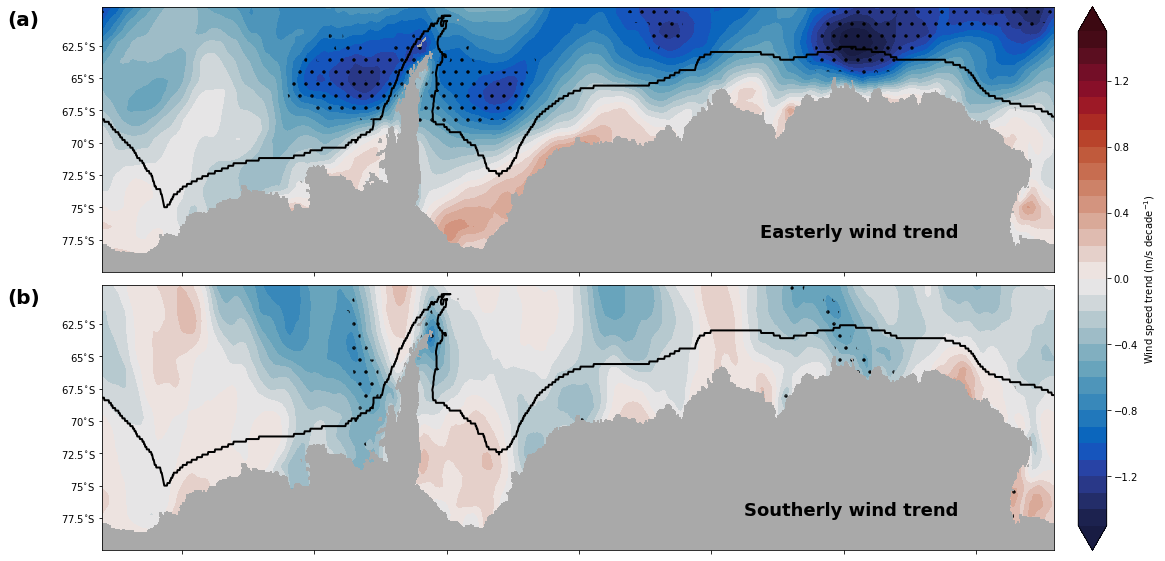

In [9]:
k = 'reanalysis'
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[:,1])]
for ax, label in zip(axs, ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

c = axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], -uas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1.5, 1.6, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], uas_trends_DJF[k]['p'].where(uas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])

c = axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1.5, 1.6, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['p'].where(vas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed trend (m/s decade$^{-1}$)')

plt.savefig('../results/v6/trends-DJF-'+k+'-pre2000.jpg', bbox_inches = 'tight', dpi = 800)

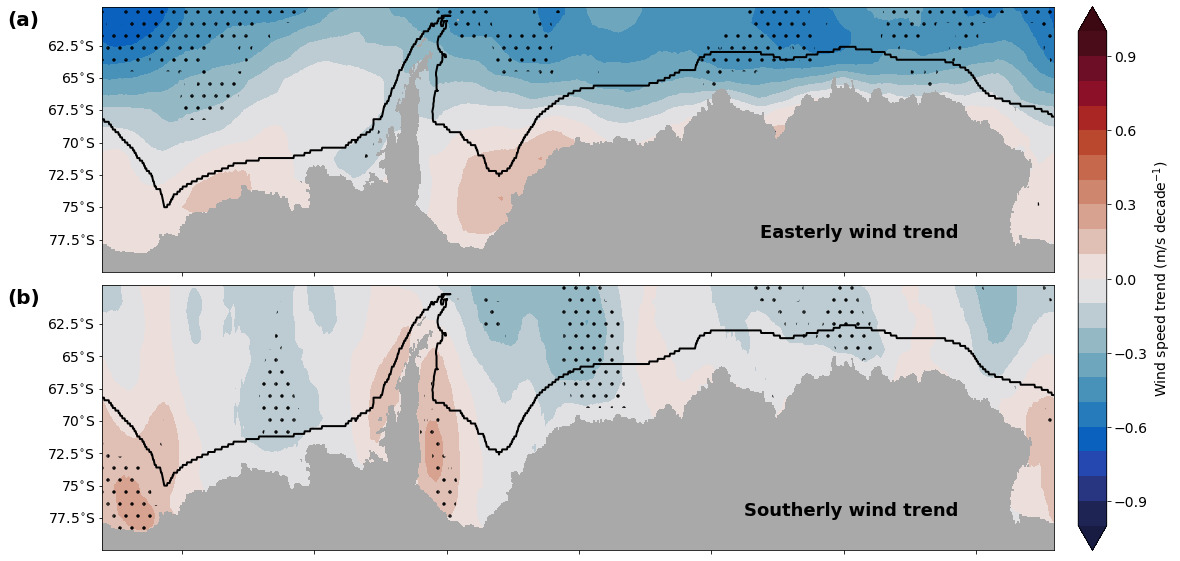

In [10]:
k = 'cmip6'
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[:,1])]
for ax, label in zip(axs, ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

c = axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], -uas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], uas_trends_DJF[k]['p'].where(uas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])

c = axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['p'].where(vas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed trend (m/s decade$^{-1}$)')
plt.savefig('../results/v6/trends-DJF-'+k+'-pre2000.jpg', bbox_inches = 'tight', dpi = 800)